## ※ Business analytics tutorial- Ensemble learning
---
본 튜토리얼은 고려대학교 강필성 교수님의 Business analytics 수업의 내용을 정리한 튜토리얼 코드 입니다.  
튜토리얼에서는 Ensemble learning의 대표적인 방법론인 **XGBoost** 에 대한 코드와 간단한 설명을 다룹니다.  

출처1: https://www.kaggle.com/code/lifesailor/xgboost

In [1]:
!pip install xgboost


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [62]:
# library 호출
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline

### loan_data를 활용한 실습 XGBoost 실습
본 실험에서는 대출 연체 여부를 예측하기 위해 구성된 데이터셋인 loan_data를 활용하여 실습을 진행합니다.  
각 변수에 대한 설명은 다음과 같습니다.  
  
<img src="images/loan_data_description.png" width="750px" height="777px" title="loan_data"/>  

본 데이터셋을 활용하여 XGBoost를 통해 성능을 평가하도록 하겠습니다.

In [63]:
# load loan data
loan_data = pd.read_csv('dataset/loan_data.csv')

In [64]:
loan_data.head()

,AGE,TOT_LOAN,TOT_LOAN_CRD,LOAN_BNK,LOAN_CPT,CRDT_CNT,GUARN_CNT,INCOME,LOAN_CRD_CNT,LATE_RATE,...,CALL_TIME,TEL_COST_MON,MOBILE_PRICE,SUSP_DAY,LATE_TEL,COMB_COMM,SEX,PAY_METHOD,JOB,TARGET
0,40,6,6,6,0,0,0,4500,0,16,...,1.52,120,500,0,120,0,M,A,A,0
1,35,9,9,0,0,1,0,3700,0,9,...,2.14,100,800,0,0,0,M,C,B,0
2,55,9,9,0,0,0,0,6400,0,1,...,0.50,50,700,0,0,0,M,C,B,0
3,55,42,0,42,0,5,0,8900,0,13,...,2.61,80,900,0,0,0,M,B,C,0
4,40,36,36,36,0,3,1,0,0,2,...,2.11,10,900,0,0,1,F,B,B,0


In [65]:
# 결측치 확인 -> 결측치가 없으므로 바로 사용

print(loan_data.isnull().sum())

AGE              0
TOT_LOAN         0
TOT_LOAN_CRD     0
LOAN_BNK         0
LOAN_CPT         0
CRDT_CNT         0
GUARN_CNT        0
INCOME           0
LOAN_CRD_CNT     0
LATE_RATE        0
LATE_RATE_1Y     0
INS_MON_MAX      0
CANCEL_CNT_1Y    0
CALL_TIME        0
TEL_COST_MON     0
MOBILE_PRICE     0
SUSP_DAY         0
LATE_TEL         0
COMB_COMM        0
SEX              0
PAY_METHOD       0
JOB              0
TARGET           0
dtype: int64


In [66]:
# 명목형 변수 one-hot encoding
loan_data_one_hot = pd.get_dummies(loan_data, columns=['SEX', 'PAY_METHOD', 'JOB'])

In [67]:
loan_data_one_hot.head()

,AGE,TOT_LOAN,TOT_LOAN_CRD,LOAN_BNK,LOAN_CPT,CRDT_CNT,GUARN_CNT,INCOME,LOAN_CRD_CNT,LATE_RATE,...,SEX_F,SEX_M,PAY_METHOD_A,PAY_METHOD_B,PAY_METHOD_C,PAY_METHOD_D,JOB_A,JOB_B,JOB_C,JOB_D
0,40,6,6,6,0,0,0,4500,0,16,...,0,1,1,0,0,0,1,0,0,0
1,35,9,9,0,0,1,0,3700,0,9,...,0,1,0,0,1,0,0,1,0,0
2,55,9,9,0,0,0,0,6400,0,1,...,0,1,0,0,1,0,0,1,0,0
3,55,42,0,42,0,5,0,8900,0,13,...,0,1,0,1,0,0,0,0,1,0
4,40,36,36,36,0,3,1,0,0,2,...,1,0,0,1,0,0,0,1,0,0


In [68]:
# 연속형 변수 normalization -> Standard scaler를 활용하여 normalization 진행

continuous_variable = ['AGE', 'TOT_LOAN', 'TOT_LOAN_CRD', 'LOAN_BNK', 'LOAN_CPT', 
'CRDT_CNT','GUARN_CNT', 'INCOME', 'LOAN_CRD_CNT', 'LATE_RATE', 'LATE_RATE_1Y',
'INS_MON_MAX', 'CANCEL_CNT_1Y', 'CALL_TIME', 'TEL_COST_MON','MOBILE_PRICE', 
'SUSP_DAY', 'LATE_TEL']

loan_data_continuos = loan_data_one_hot[continuous_variable]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(loan_data_continuos)
loan_data_continuos_scaled = scaler.transform(loan_data_continuos)

#scale 연속형 변수 dataframe화
dataframe_continuous = pd.DataFrame(loan_data_continuos_scaled,
 columns= continuous_variable)

# scale 연속형 변수와 명목형 변수 합치기
dataframe_scaled = pd.concat([dataframe_continuous, loan_data_one_hot.drop(columns=continuous_variable)], axis =1)

### XGBoost hyperparameter 탐색  
**XGBoost**는 매우 다양한 종류의 hyperparameter를 갖고 있습니다. 크게 **General parmeter, Boost Parameter, Learning Task Parameter** 3가지로 XGBoost의 하이퍼파라미터를 분류할 수 있습니다. 각각에 대한 설명과 각 하이퍼파라미터 군집에 구체적으로 어떠한 하이퍼파라미터가 있는지에 대한 설명은 아래와 같습니다.

- **General parmeter**: 전체적인 기능에 대한 가이드를 주는 하이퍼파라미터

    <img src="images/general_para.png" width="765px" height="169px" title="general_para">  
      

- **Boost Parameter**: 모델 성능에 가장 큰 영향을 주는 하이퍼파라미터로 모델의 과적합 등의 이슈 발생시 조절하는 하이퍼파라미터
  
    <img src="images/boost_para.png" width="765px" height="576px" title="boost_para">  
      
  
- **train Parameter**: 학습에 활용되는 objective function, eval metric등을 포함하는 하이퍼파라미터  
  
    <img src="images/train_para.png" width="765px" height="125px" title="train_para">  


위에서 설명한 hyperparameter들에 대하여 kfold validation을 통해 최적의 hyperparameter 조합을 찾고 성능을 산출합니다.


### Optuna를 활용한 XGBoost hyperparameter 탐색  
**XGBoost**는 위에서 언급한 것과 같이 매우 다양한 종류의 하이퍼파라미터를 갖습니다. 따라서 모든 하이퍼파라미터에 대해 최적화를 진행하는 것은 굉장히 많은 시간과 노력이 필요하면 이는 비효율적입니다. 본 튜토리얼에서는 **optuna** 라는 라이브러리를 활용하여 효율적인 하이퍼파라미터 탐색을 진행하고자 합니다. optuna는 하이퍼파라미터 탐색에 가장 많이 사용되는 라이브러리 중 하나로 지정한 범위 내의 하이퍼파라미터를 바탕으로 효율적인 탐색을 가능하도록 구현되어 있습니다. 또한 다양한 시각화 기능이 있는점도 매우 유용합니다. 본 튜토리얼에서는 optuna를 활용하여 하이퍼파라미터 탐색을 진행하겠습니다.

In [69]:
# train dataset, test dataset 분리
from sklearn.model_selection import train_test_split
test_size = 0.2
test_num = int(dataframe_scaled.shape[0] * test_size)
train_num = dataframe_scaled.shape[0] - test_num
train_idx = np.random.choice(dataframe_scaled.shape[0], train_num, replace=False)
test_idx = np.setdiff1d(range(dataframe_scaled.shape[0]), train_idx)

train_dataset = dataframe_scaled.iloc[train_idx]
test_dataset = dataframe_scaled.iloc[test_idx]

In [70]:
len(train_dataset) , len(test_dataset)

(34709, 8677)

In [71]:
# target 설정
X=train_dataset.drop('TARGET',axis=1)
y=train_dataset['TARGET']

In [72]:
import warnings
warnings.filterwarnings(action='ignore') 

In [73]:
# optuna 설정
from sklearn.metrics import log_loss

def objective(trial,train=train_dataset,target=y):

  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2)

  param={
      'max_depth':trial.suggest_int('max_depth',5,20),
      'learning_rate':trial.suggest_uniform('learning_rate',0.0001,0.99),
      'subsample':trial.suggest_discrete_uniform('subsample', 0.6,1.0,0.1),
      'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.3,0.9,0.1),
      'n_estimators': trial.suggest_int("n_estimators", 1000, 10000, 100),
      'eval_metric': 'logloss',
      'objective' : 'binary:logistic',
      'random_state': 2,
      'n_estimators': 1000
  }

  model=XGBClassifier(**param)

  bst = model.fit(X_train,y_train,eval_set=[(X_test,y_test)],verbose=False)

  predictions=bst.predict_proba(X_test)

  logloss = log_loss(y_test,predictions)
  return logloss

In [74]:
import optuna

In [75]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
study.best_params

[I 2022-11-28 14:29:43,696] A new study created in memory with name: no-name-49534732-1d19-4cf6-9478-3bbd54b495ee
[I 2022-11-28 14:29:49,015] Trial 0 finished with value: 0.40506236182221156 and parameters: {'max_depth': 14, 'learning_rate': 0.6425917597372677, 'subsample': 0.6, 'colsample_bytree': 0.8, 'n_estimators': 3000}. Best is trial 0 with value: 0.40506236182221156.
[I 2022-11-28 14:29:54,619] Trial 1 finished with value: 0.37840166122876906 and parameters: {'max_depth': 17, 'learning_rate': 0.5088011291610081, 'subsample': 0.6, 'colsample_bytree': 0.8, 'n_estimators': 9500}. Best is trial 1 with value: 0.37840166122876906.
[I 2022-11-28 14:29:57,980] Trial 2 finished with value: 0.3978309917654947 and parameters: {'max_depth': 12, 'learning_rate': 0.9158228503559029, 'subsample': 1.0, 'colsample_bytree': 0.4, 'n_estimators': 3700}. Best is trial 1 with value: 0.37840166122876906.
[I 2022-11-28 14:30:04,036] Trial 3 finished with value: 0.2960315315826381 and parameters: {'max_

{'max_depth': 10,
 'learning_rate': 0.007610762302910637,
 'subsample': 0.7,
 'colsample_bytree': 0.7,
 'n_estimators': 3900}

In [83]:
# Accuracy 함수 구현
from sklearn.metrics import accuracy_score

def calculate_accuracy(model, x_test, y_test):
    # make predictions
    y_pred = model.predict(x_test)
    predictions = [round(value) for value in y_pred]
    
    # evaluations
    accuracy = accuracy_score(y_test, predictions)
    print('Accuracy: %.2f%%' % (accuracy * 100.0))
    return accuracy

In [84]:
# target 설정
X_test=test_dataset.drop('TARGET',axis=1)
y_test=test_dataset['TARGET']

In [86]:
# test 진행
model=XGBClassifier(**study.best_params)
model.fit(X,y)
# print(model.evals_result)
calculate_accuracy(model, X_test, y_test)

Accuracy: 93.06%


0.930621182436326

In [111]:
y_pred = model.predict_proba(X_test)[:,1]

In [113]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred)


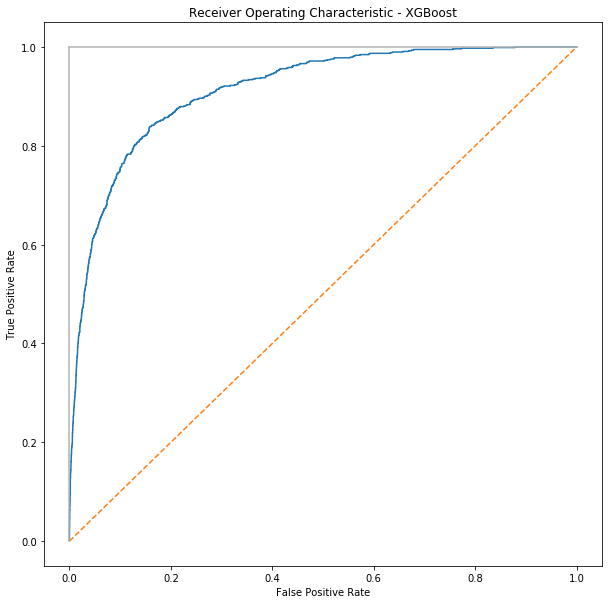

roc_auc_score for XGBoost:  0.9129710810247044


In [117]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print('roc_auc_score for XGBoost: ', roc_auc_score(y_test, y_pred))

# 실험결과

optuna library를 활용하여 max_depth, learning_rate, subsample, colsample_bytree, n_estimators에 대한 최적화를 진행하였습니다. 각각의 하이퍼파라미터에 대한 최적화 결과는 {'max_depth': 10, 'learning_rate': 0.007610762302910637 'subsample': 0.7, 'colsample_bytree': 0.7, 'n_estimators': 3900} 입니다. 해당 하이퍼파라미터 집합을 통해 test result를 산출한 결과 93.06%의 정확도를 달성하였습니다. 또한 AUC score 역시 0.91을 기록하여 상당히 높은 값을 산출한 것을 알 수 있었습니다. 즉 주어진 loan dataset은 XGBoost가 굉장히 높은 수준의 예측을 진행하고 있음을 알 수 있었습니다.  
이러한 XGBoost의 가장 큰 장점 중 하나는 XAI 즉 어떤 부분으로 인해 model이 이러한 결과를 산출했는지에 대한 시각적인 지표를 제공한다는 점 입니다.  
XGBoost가 제공하는 feature importance, shaply 변수를 통해 사후분석을 진행하도록 하겠습니다.  

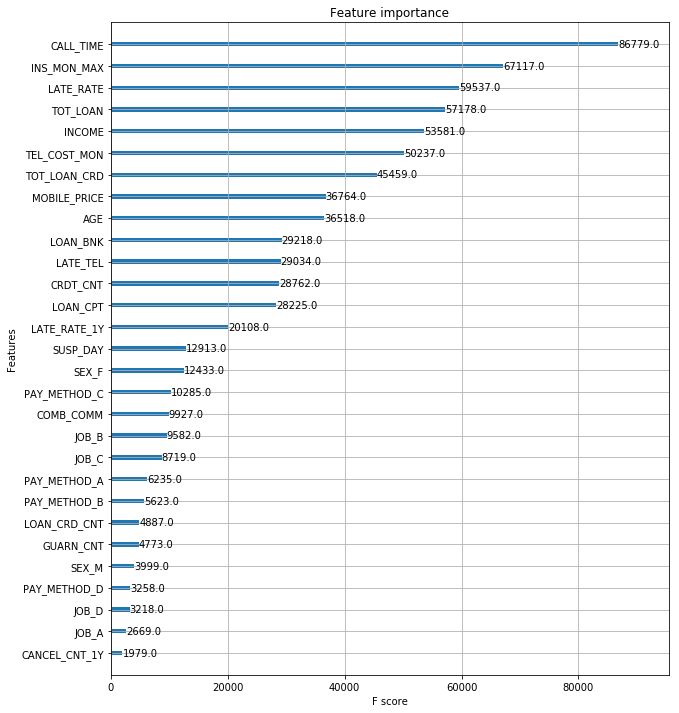

In [96]:
from xgboost import plot_importance
fig, ax=plt.subplots(figsize=(10,12))
plot_importance(model, ax=ax)

### Feature importance 분석
Feature importance 산출 결과 CALL_TIME(월별 통화시간), INS_MON_MAX(월납입보험료), LATE_RATE(보험료 연체율)이 높은 importance를 기록하였습니다. 다만 XGBoost에서 제공하는 feature importance의 경우 각 feature가 양의 방향으로 영향을 주었는지, 음의 방향으로 영향을 주었는지에 대한 부분은 정보를 제공하지 못합니다. 

In [9]:
!pip install shap


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [10]:
import shap

ModuleNotFoundError: No module named 'numba.core'

In [11]:
import numpy

In [18]:
import shap

ModuleNotFoundError: No module named 'numba.core'

In [17]:
!pip freeze

alabaster==0.7.11
alembic==1.8.1
anaconda-client==1.7.2
anaconda-navigator==1.9.2
anaconda-project==0.8.2
antlr4-python3-runtime==4.8
appdirs==1.4.3
asn1crypto==0.24.0
astroid==2.0.4
astropy==3.0.4
async-generator==1.10
atomicwrites==1.2.1
attrs==22.1.0
Automat==0.7.0
autopage==0.5.1
Babel==2.6.0
backcall==0.1.0
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.8.2
bitarray==0.8.3
bkcharts==0.2
blaze==0.11.3
bleach==2.1.4
bokeh==0.13.0
boto==2.49.0
Bottleneck==1.2.1
certifi==2018.8.24
cffi==1.11.5
chardet==3.0.4
charset-normalizer==2.1.0
click==6.7
cliff==3.10.1
cloudpickle==0.5.5
clyent==1.2.2
cmaes==0.8.2
cmd2==2.4.2
colorama==0.3.9
colorlog==6.7.0
conda==4.5.11
conda-build==3.15.1
constantly==15.1.0
contextlib2==0.5.5
cryptography==2.3.1
cycler==0.10.0
Cython==0.28.5
cytoolz==0.9.0.1
dask==0.19.1
datashape==0.5.4
decorator==4.3.0
defusedxml==0.5.0
distlib==0.3.5
distributed==1.23.1
docutils==0.14
entrypoints==0.2.3
et-xmlfile==1.0.1
fastcache==1.0.2
filelock==3.8.0
Flask==

In [13]:
! pip install numba --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 24.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 37.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.24.0
ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


ERROR: unknown command "freezee" - maybe you meant "freeze"


In [8]:
import shap

ModuleNotFoundError: No module named 'numba.core'